# Evaluating cloud dilation options for Landsat Fmask <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls9c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls9c_ard_3)



## Getting started

### Load packages
Import Python packages used for the analysis.


In [1]:
import datacube
from datacube.utils.masking import make_mask
from odc.algo import mask_cleanup

import sys

sys.path.insert(1, "../Tools/")
from dea_tools.dask import create_local_dask_cluster

# Launch Dask cluster
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/aaron.ohehir@ga.gov.au/proxy/8787/status,
Dashboard: /user/aaron.ohehir@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38865,Workers: 1
Dashboard: /user/aaron.ohehir@ga.gov.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:46029,Total threads: 2
Dashboard: /user/aaron.ohehir@ga.gov.au/proxy/38675/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:45027,


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Testing_cloud_dilation")

## Load data


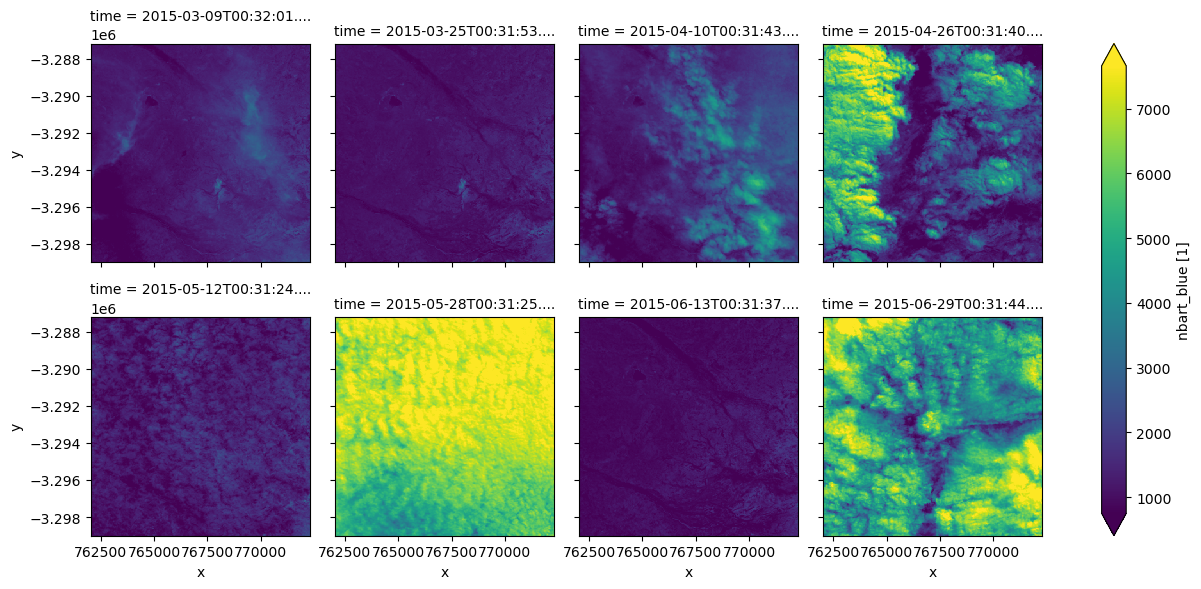

In [3]:
# Select spatiotemporal query (can be replaced with scene path/row)
query_params = dict(x=(140, 140.1), y=(-30, -30.1), time=("2015", "2016"))

# Set load params (measurements to load, Dask chunking, resampling etc)
load_params = dict(measurements=["nbart_blue", "oa_fmask"], dask_chunks={})

# Lazily load data
ds = dc.load(product="ga_ls8c_ard_3", **query_params, **load_params)

# Plot
ds.nbart_blue.isel(time=slice(4, 12)).plot.imshow(col="time", robust=True, col_wrap=4)

## Fmask cloud and shadow mask
Based on content from: https://docs.dea.ga.gov.au/notebooks/How_to_guides/Masking_data.html

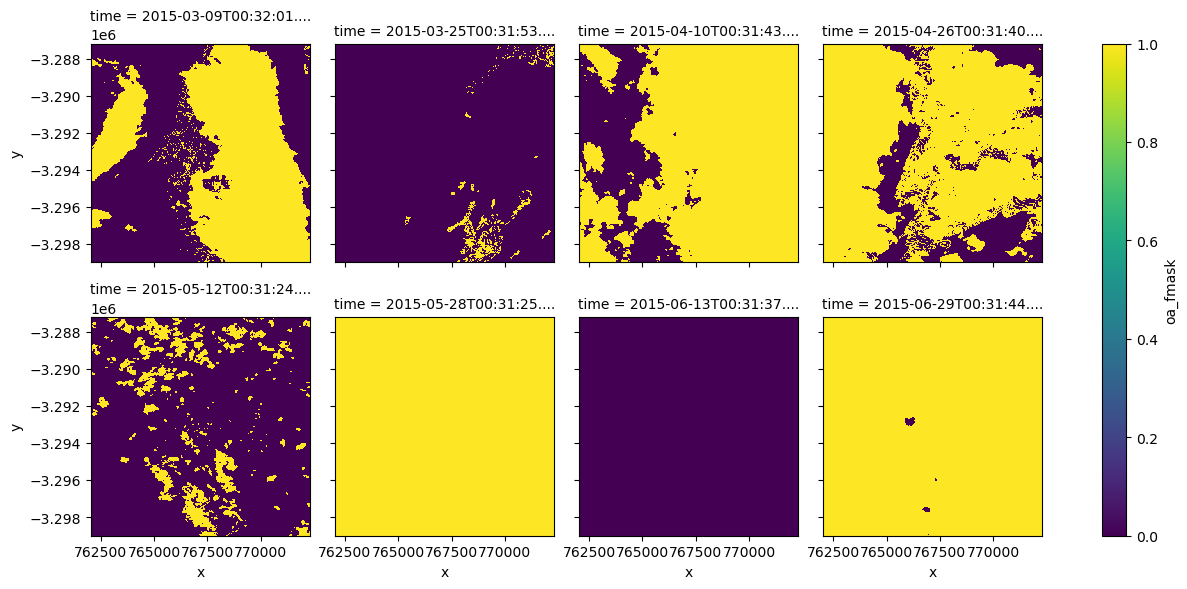

In [4]:
# Identify pixels that are either "cloud" or "cloud_shadow"
cloud_shadow_mask = make_mask(ds.oa_fmask, fmask="cloud") | make_mask(
    ds.oa_fmask, fmask="shadow"
)

# Plot
cloud_shadow_mask.isel(time=slice(4, 12)).plot(col="time", col_wrap=4)

### Applying dilation using `mask_cleanup`

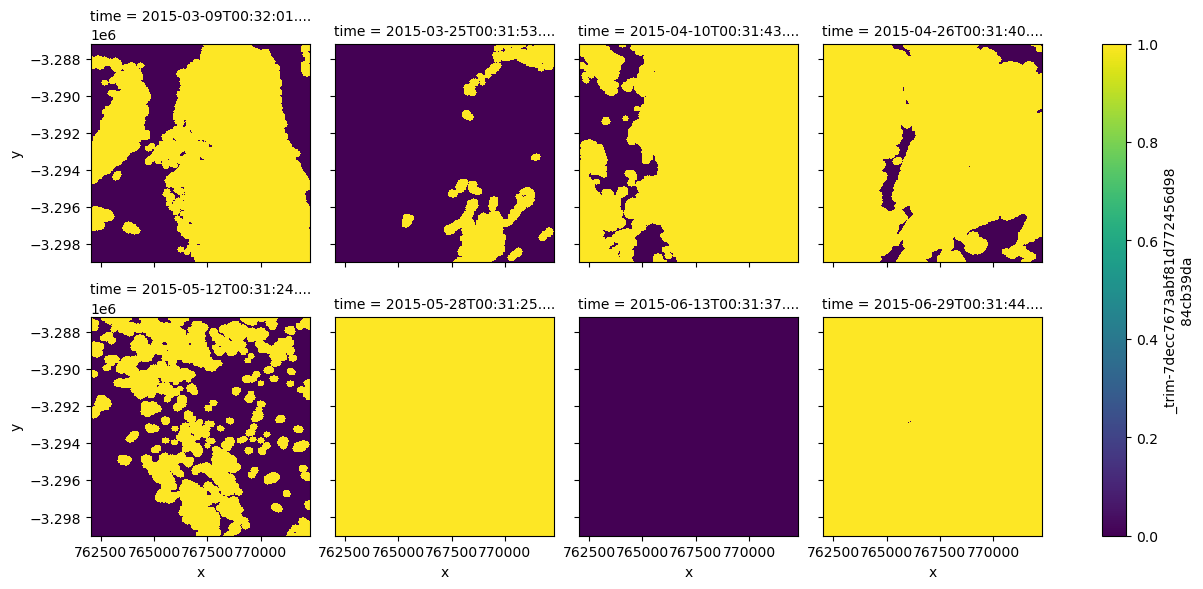

In [58]:
# Dilate all cloud and cloud shadow pixels by 5 pixels (uses a circular disk)
cloud_shadow_buffered = mask_cleanup(
    mask=cloud_shadow_mask, mask_filters=[("dilation", 5)]
)

# Plot
cloud_shadow_buffered.isel(time=slice(4, 12)).plot(col="time", col_wrap=4)

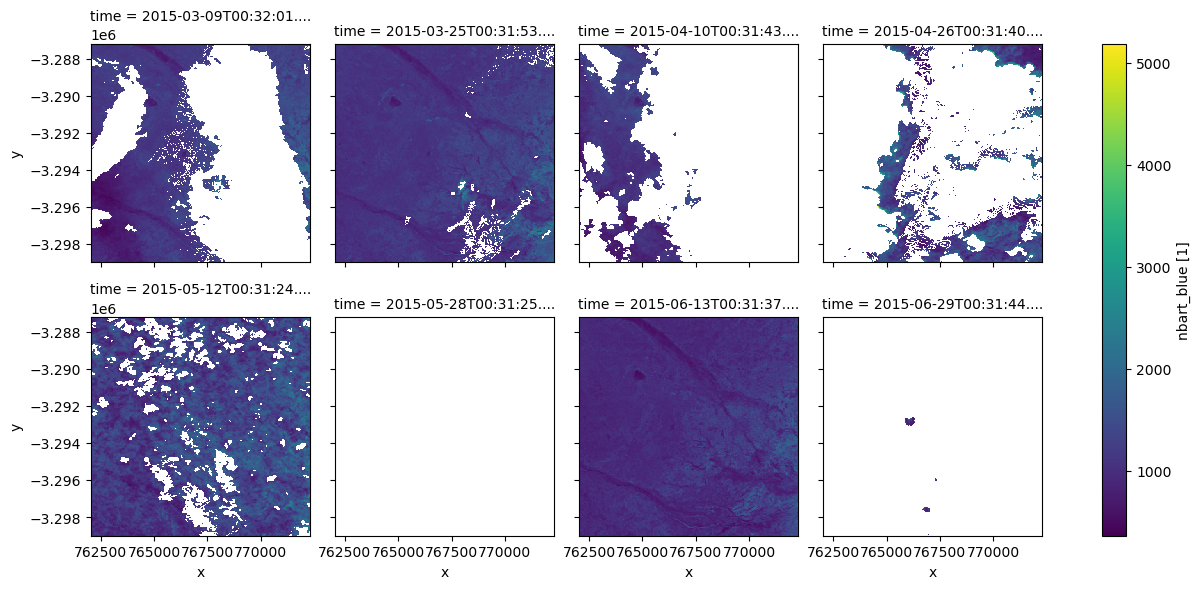

In [44]:
# apply mask with 0 dilation to blue band

# Apply the mask
clear = ds.where(~cloud_shadow_mask)

clear.nbart_blue.isel(time=slice(4, 12)).plot(col="time", col_wrap=4)

In [46]:
# std for time slice 5 with 0 dilation
clear.load()
clear['nbart_blue'].isel(time=5).std()

<xarray.DataArray 'nbart_blue' ()>
array(191.71558538)
Coordinates:
    time         datetime64[ns] 2015-03-25T00:31:53.144598
    spatial_ref  int32 3577

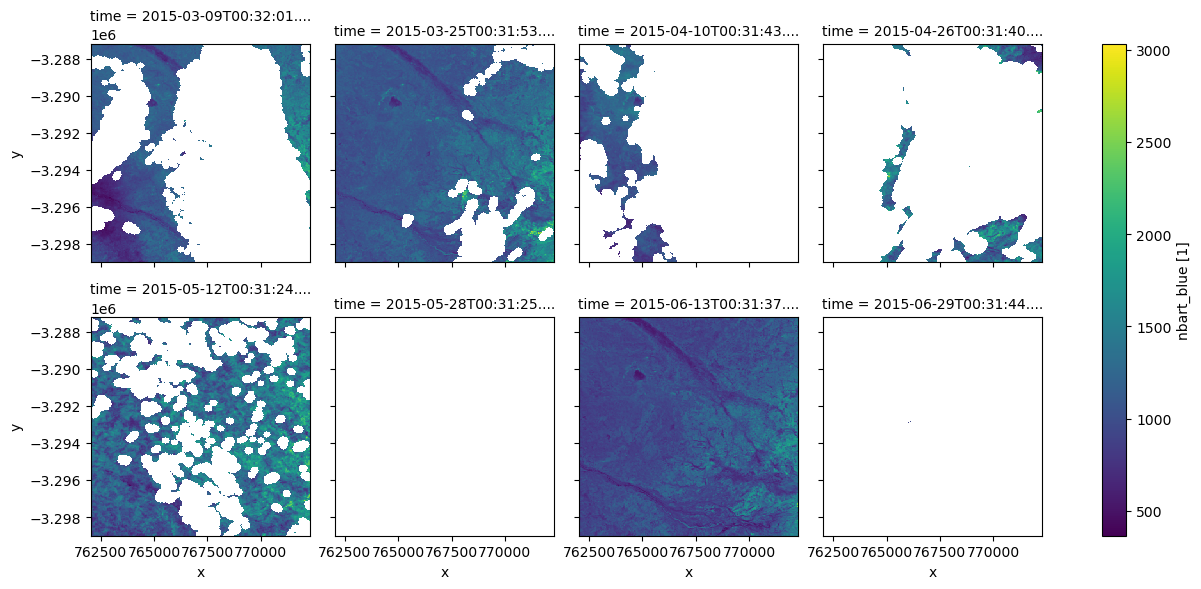

In [59]:
# apply mask with 5 dilation to blue band

# Apply the mask
clear_buffered = ds.where(~cloud_shadow_buffered)

clear_buffered.nbart_blue.isel(time=slice(4, 12)).plot(col="time", col_wrap=4)

In [60]:
# std for time slice 5 with 5 dilation
clear_buffered.load()
clear_buffered['nbart_blue'].isel(time=5).std()

<xarray.DataArray 'nbart_blue' ()>
array(186.64671377)
Coordinates:
    time         datetime64[ns] 2015-03-25T00:31:53.144598
    spatial_ref  int32 3577

In [72]:
for i in clear_buffered.nbart_blue.isel(time=slice(4, 12)):
    print(i.std())


<xarray.DataArray 'nbart_blue' ()>
array(261.91454096)
Coordinates:
    time         datetime64[ns] 2015-03-09T00:32:01.894986
    spatial_ref  int32 3577
<xarray.DataArray 'nbart_blue' ()>
array(186.64671377)
Coordinates:
    time         datetime64[ns] 2015-03-25T00:31:53.144598
    spatial_ref  int32 3577
<xarray.DataArray 'nbart_blue' ()>
array(165.62672093)
Coordinates:
    time         datetime64[ns] 2015-04-10T00:31:43.936475
    spatial_ref  int32 3577
<xarray.DataArray 'nbart_blue' ()>
array(318.22254298)
Coordinates:
    time         datetime64[ns] 2015-04-26T00:31:40.296571
    spatial_ref  int32 3577
<xarray.DataArray 'nbart_blue' ()>
array(283.69446601)
Coordinates:
    time         datetime64[ns] 2015-05-12T00:31:24.329507
    spatial_ref  int32 3577
<xarray.DataArray 'nbart_blue' ()>
array(nan)
Coordinates:
    time         datetime64[ns] 2015-05-28T00:31:25.984770
    spatial_ref  int32 3577
<xarray.DataArray 'nbart_blue' ()>
array(182.41362992)
Coordinates:
    time   

In [73]:
for i in clear.nbart_blue.isel(time=slice(4, 12)):
    print(i.std())

<xarray.DataArray 'nbart_blue' ()>
array(255.56538863)
Coordinates:
    time         datetime64[ns] 2015-03-09T00:32:01.894986
    spatial_ref  int32 3577
<xarray.DataArray 'nbart_blue' ()>
array(191.71558538)
Coordinates:
    time         datetime64[ns] 2015-03-25T00:31:53.144598
    spatial_ref  int32 3577
<xarray.DataArray 'nbart_blue' ()>
array(197.5062149)
Coordinates:
    time         datetime64[ns] 2015-04-10T00:31:43.936475
    spatial_ref  int32 3577
<xarray.DataArray 'nbart_blue' ()>
array(450.56793443)
Coordinates:
    time         datetime64[ns] 2015-04-26T00:31:40.296571
    spatial_ref  int32 3577
<xarray.DataArray 'nbart_blue' ()>
array(287.60285259)
Coordinates:
    time         datetime64[ns] 2015-05-12T00:31:24.329507
    spatial_ref  int32 3577
<xarray.DataArray 'nbart_blue' ()>
array(nan)
Coordinates:
    time         datetime64[ns] 2015-05-28T00:31:25.984770
    spatial_ref  int32 3577
<xarray.DataArray 'nbart_blue' ()>
array(182.41362992)
Coordinates:
    time    

In [77]:
#clear.nbart_blue.std("time").mean()
clear.std("time").mean()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int32 3577
Data variables:
    nbart_blue   float64 175.2
    oa_fmask     float64 0.001414

In [86]:
def get_std(buffer_size, ds): 
    # Dilate all cloud and cloud shadow pixels by n pixels (uses a circular disk)
    cloud_shadow_buffered = mask_cleanup(
        mask=cloud_shadow_mask, mask_filters=[("dilation", buffer_size)]
    )
    
    # Apply the mask
    clear_buffered = ds.where(~cloud_shadow_buffered)
    
    # load into memory
    clear_buffered.load()
    
    # calculate mean of std for time series
    return int(clear_buffered.nbart_blue.std("time").mean())

get_std(6, ds)

buffer_sizes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for buffer in buffer_sizes:
    print('Buffer: ',str(buffer),'std: ',str(get_std(buffer,ds)))

Buffer:  0 std:  175
Buffer:  1 std:  165
Buffer:  2 std:  160
Buffer:  3 std:  156
Buffer:  4 std:  153
Buffer:  5 std:  150
Buffer:  6 std:  148
Buffer:  7 std:  146
Buffer:  8 std:  144
Buffer:  9 std:  142
Buffer:  10 std:  141
Buffer:  11 std:  140
Buffer:  12 std:  138
Buffer:  13 std:  137
Buffer:  14 std:  136
Buffer:  15 std:  135
Buffer:  16 std:  135
Buffer:  17 std:  134
Buffer:  18 std:  133
Buffer:  19 std:  133
Buffer:  20 std:  132


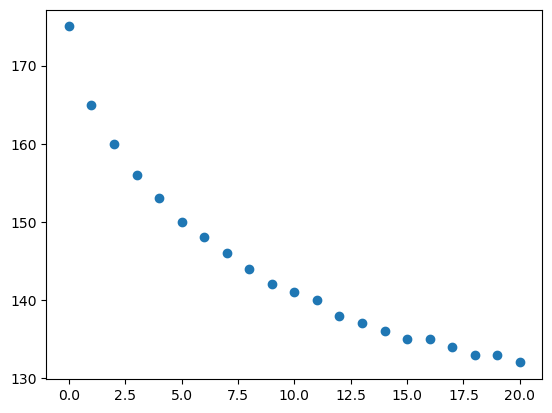

In [87]:
buffer_sizes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
std = [175,165,160,156,153,150,148,146,144,142,141,140,138,137,136,135,135,134,133,133,132]

import matplotlib.pyplot as plt

plt.xlabel("buffer distance")
plt.ylabel("std")

plt.scatter(buffer_sizes, std)
plt.show()


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 2023

**Compatible datacube version:** 

In [6]:
print(datacube.__version__)

1.8.13


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)